# Estimating photometric redshifts with RAIL stages and comparing results for different parameters

**Authors:** Jennifer Scora

**Last run successfully:** Feb 4, 2025

**TO DO: Update all links to docs and notebooks once the documentation is up for version 2**


This notebook shows how to run through the various [stages of RAIL](https://descraildocs.z27.web.core.windows.net/source/rail_stages/what_are_rail_stages.html) (creation, estimation, evaluation) in order to create a simulated dataset of galaxy magnitudes and redshifts, use the magnitudes to estimate photometric redshifts, and then compare the resulting estimated photometric redshifts to the *true* redshifts. We will be using the [K-Nearest Neighbour algorithm](https://rail-hub.readthedocs.io/en/latest/source/estimators.html#k-nearest-neighbor) (KNN) to estimate redshifts, and testing out how the limits on the number of nearest neighbours affect the resulting esimated redshift distributions. 

To do this, we loop over the estimation and evaluation stages while varying these parameters to test their effect. We will also then be exploring how we can parallelize this loop within the notebook to speed things up a little. However, if you are running on very large datasets, we recommend running in pipeline mode instead (see instructions [here](https://descraildocs.z27.web.core.windows.net/source/user_guide/pipeline_usage.html)), as it is not possible to loop over large files with the interactive mode of RAIL. 

Here are the steps that we're going to cover in this notebook:

1. Creating a realistic data set of galaxy magnitudes and true redshifts 
2. Estimating the photometric redshifts
3. Summarizing the redshift distributions
4. Evaluating the photometric redshifts against the *true* values
6. Repeating steps 2-4 with a parallelized loop

Before we get started, here's a quick introduction to some of the features of RAIL interactive mode. The only RAIL package you need to import is the `rail.interactive` package. This contains all of the interactive functions for all of the RAIL algorithms. You may need to import supporting functions that are not part of a stage separately. To get a sense of what functions/stages are available and for some more detailed instructions, see [the RAIL documentation](https://descraildocs.z27.web.core.windows.net/source/user_guide/interactive_usage.html).  

In [9]:
# import the packages we'll need
import rail.interactive as ri

To get the docstrings for a function, including what parameters it needs and what it returns, you can just put a question mark after the function call or use the `help()` function, as you would with any python function. 

In [10]:
ri.creation.engines.flowEngine.flow_modeler?

Signature:       ri.creation.engines.flowEngine.flow_modeler(**kwargs) -> Any
Call signature:  ri.creation.engines.flowEngine.flow_modeler(*args, **kwargs)
Type:            partial
String form:     functools.partial(<function _interactive_factory at 0x76c41c9547c0>, <class 'rail.creation.engines.flowEngine.FlowModeler'>, False, True)
File:            ~/software/anaconda3/envs/rail/lib/python3.12/functools.py
Docstring:      
Modeler wrapper for a PZFlow Flow object.

This class trains the flow.

---

Produce a creation model from which photometry and redshifts can be
generated.

---

This function was generated from the function
rail.creation.engines.flowEngine.FlowModeler.fit_model

Parameters
----------
input : DataHandle
    ???
seed : int, optional
    The random seed for training.
    Default: 0
phys_cols : dict, optional
    Names of non-photometry columns and their corresponding [min, max] values.
    Default: {'redshift': [0, 3]}
phot_cols : dict, optional
    Names of photomet

## 1. Creating a realistic data set of galaxy magnitudes and true redshifts

First we want to create the data sets of galaxy magnitudes that we will use to estimate photometric redshifts. We will use PZflow to generate our model, and then pull two data sets from the model, a training dataset and a test dataset. The training data set will be used to train our models, and the test data set is the data we will get photo-z estimates for. We'll then degrade these datasets so that they better resemble real data from the Rubin telescope. 

In [11]:
# importing some supplementary packages and functions
import numpy as np
from pzflow.examples import get_galaxy_data

# plotting imports
import matplotlib.pyplot as plt

%matplotlib inline

Here we first need to set up some column name dictionaries, as the expected column names vary between some of the codes. In order to handle this, we can pass in  dictionaries of expected column names and the column name that exists in the input data (`band_dict` and `rename_dict` below). In this notebook, we are using bands ugrizy, and each band will have a name 'mag_u_lsst', for example, with the error column name being 'mag_err_u_lsst'. 

The initial data we pull from our model won't have any associated errors. Those will be created when we degrade the datasets, but the error columns will need to be renamed with the `rename_dict` later on.

In [12]:
bands = ["u", "g", "r", "i", "z", "y"]
band_dict = {band: f"mag_{band}_lsst" for band in bands}
rename_dict = {f"mag_{band}_lsst_err": f"mag_err_{band}_lsst" for band in bands}

In order to generate the model with PZflow, we need to grab some sample data to base the model off of. This sample data is only used to create the model, and is seperate from the training and test data we'll get from the model later.

Now we grab the galaxy data we'll use to train our creation model, and we'll rename the band columns to match our desired band names as discussed above, using `band_dict`. We can check that our columns have been renamed appropriately by printing out the first few lines of the table.

In [13]:
catalog = get_galaxy_data().rename(band_dict, axis=1)
# let's take a look at the columns
catalog.head()

,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,0.287087,26.759261,25.901778,25.187710,24.932318,24.736903,24.671623
1,0.293313,27.428358,26.679299,25.977161,25.700094,25.522763,25.417632
2,1.497276,27.294001,26.068798,25.450055,24.460507,23.887221,23.206112
3,0.283310,28.154075,26.283166,24.599570,23.723491,23.214108,22.860012
4,1.545183,29.276065,27.878301,27.333528,26.543374,26.061941,25.383056


Looks like the column names are the way we want them! 

### Train and sample the model

Now we need to use the galaxy data we retrieved to train the model that we'll use to create our input galaxy magnitude data catalogues later. We're going to use the `PZflow` engine to do this, specifically the `modeler` function. This will train the normalizing flow that serves as the engine for the input data creation. To get a sense of what it does and the parameters it needs, let's check out its docstrings:

In [14]:
ri.creation.engines.flowEngine.flow_modeler?

Signature:       ri.creation.engines.flowEngine.flow_modeler(**kwargs) -> Any
Call signature:  ri.creation.engines.flowEngine.flow_modeler(*args, **kwargs)
Type:            partial
String form:     functools.partial(<function _interactive_factory at 0x76c41c9547c0>, <class 'rail.creation.engines.flowEngine.FlowModeler'>, False, True)
File:            ~/software/anaconda3/envs/rail/lib/python3.12/functools.py
Docstring:      
Modeler wrapper for a PZFlow Flow object.

This class trains the flow.

---

Produce a creation model from which photometry and redshifts can be
generated.

---

This function was generated from the function
rail.creation.engines.flowEngine.FlowModeler.fit_model

Parameters
----------
input : DataHandle
    ???
seed : int, optional
    The random seed for training.
    Default: 0
phys_cols : dict, optional
    Names of non-photometry columns and their corresponding [min, max] values.
    Default: {'redshift': [0, 3]}
phot_cols : dict, optional
    Names of photomet

We'll pass the modeler a few parameters:
- **input:** this is the input catalog that our modeler needs to train the data flow (the one we retrieved above)
- **seed (optional):** this is the random seed used for training
- **phys_cols (optional):** The names of any non-photometry columns and their [min,max] values.
- **phot_cols (optional):** This is a dictionary of the names of the photometry columns and their corresponding [min,max] values.
- **calc_colors (optional):** Whether to internally calculate colors (if phot_cols are magnitudes). Assumes that you want to calculate colors from adjacent columns in phot_cols. If you do not want to calculate colors, set False. Else, provide a dictionary `{‘ref_column_name’: band}`, where band is a string corresponding to the column in phot_cols you want to save as the overall galaxy magnitude. 
- **num_training_epochs (optional):** By default 30, here we're doing fewer so that it doesn't take as long. 


**NOTE:** This training may take a while depending on your setup. 

In [15]:
flow_model = ri.creation.engines.flowEngine.flow_modeler(
    input=catalog,
    seed=0,
    phys_cols={"redshift": [0, 3]},
    phot_cols={
        "mag_u_lsst": [17, 35],
        "mag_g_lsst": [16, 32],
        "mag_r_lsst": [15, 30],
        "mag_i_lsst": [15, 30],
        "mag_z_lsst": [14, 29],
        "mag_y_lsst": [14, 28],
    },
    calc_colors={"ref_column_name": "mag_i_lsst"},
    num_training_epochs=10
)

Inserting handle into data store.  input: None, FlowModeler
Training 10 epochs 
Loss:
(0) 21.3266
(1) 3.9686
(2) 1.9351
(3) 5.2006
(4) -0.3579
(5) 2.2561
(6) 1.5917
(7) 0.3691
(8) -1.0218
(9) inf
Training stopping after epoch 9 because training loss diverged.
Inserting handle into data store.  model: inprogress_model.pkl, FlowModeler


Now, if you take a look at the output of this function, you can see that it's a dictionary with the key 'model', since that's what we're generating, and the actual model object as the value. If there were multiple outputs for this function, they would all be collected in this dictionary: 

In [16]:
print(flow_model)

{'model': <pzflow.flow.Flow object at 0x76c2db9c8ec0>}


Now we'll use the flow to produce some synthetic data for our training data set, which we'll need to train the KNN estimation algorithm later. We'll just create a small dataset of 250 galaxies for this sample, so we'll pass in the argument: `n_samples = 250`. We'll also (optionally) use a specific seed for this so that it's reproducible. 

**Note that when we pass the model to this function, we don't pass the dictionary, but the actual model object. This is true of all the interactive functions.** 

In [17]:
# sample training data set from the model
train_data_orig = ri.creation.engines.flowEngine.flow_creator(
    n_samples=250, model=flow_model["model"], seed=1235
)

Inserting handle into data store.  model: <pzflow.flow.Flow object at 0x76c2db9c8ec0>, FlowCreator
Inserting handle into data store.  output: inprogress_output.pq, FlowCreator


Now we can look at the output from this function -- as before, it's a dictionary. Here the key is 'output' instead of model, and the data is just given as a table:

In [18]:
print(train_data_orig)

{'output':      redshift  mag_u_lsst  mag_g_lsst  mag_r_lsst  mag_i_lsst  mag_z_lsst  \
0    0.895023   24.430367   24.113907   23.363075   22.551493   22.109159   
1    0.326773   25.748173   24.443707   23.225206   22.850914   22.652538   
2    0.852999   25.977020   25.793528   25.186785   24.497295   24.103645   
3    0.654249   29.089705   28.129740   26.982731   26.261055   25.980524   
4    2.293210   29.600502   28.402340   27.379429   27.160976   26.637035   
..        ...         ...         ...         ...         ...         ...   
245  1.015558   28.062887   27.296202   26.161701   25.183062   24.598797   
246  2.049762   26.137064   26.092600   25.835526   25.786034   25.644787   
247  1.432775   27.538952   27.002316   26.934074   26.385996   25.773054   
248  0.702483   29.039577   28.428776   27.011915   26.079687   25.695610   
249  0.491151   26.850525   25.866901   24.678297   24.320053   24.120956   

     mag_y_lsst  
0     31.659264  
1     22.381588  
2     24.0

Now let's do the same thing, except this time we're going to grab our testing data set. This data set is our 'actual' data set, that we'll feed into the KNN estimation model to get our redshifts. Again, we'll just create a small dataset of 250 galaxies, and we'll use a different seed to ensure that the data won't be the same as the training set. 

In [19]:
# sample test data set from the model
test_data_orig = ri.creation.engines.flowEngine.flow_creator(
    model=flow_model["model"], n_samples=250, seed=1234
)

Inserting handle into data store.  model: <pzflow.flow.Flow object at 0x76c2db9c8ec0>, FlowCreator
Inserting handle into data store.  output: inprogress_output.pq, FlowCreator


Let's check out the distributions of galaxy redshifts, just to make sure they aren't the same:

Text(0, 0.5, 'number of galaxies')

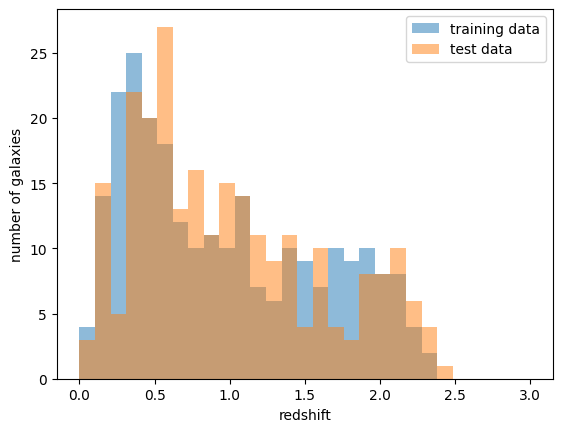

In [20]:
hist_options = {"bins": np.linspace(0, 3, 30), "histtype": "stepfilled", "alpha": 0.5}

plt.hist(train_data_orig["output"]["redshift"], label="training data", **hist_options)
plt.hist(test_data_orig["output"]["redshift"], label="test data", **hist_options)
plt.legend(loc="best")
plt.xlabel("redshift")
plt.ylabel("number of galaxies")

### Degrade the data sets

Next we will apply some degradation functions to the data, to make it look more like real observations. We apply the following functions to the training data set:
1. `lsst_error_model` to add photometric errors that are modelled based on the telescope
2. `inv_redshift_incompleteness` to mimic redshift dependent incompleteness
3. `line_confusion` to simulate the effect of misidentified lines 
4. `quantity_cut` mimics a band-dependent brightness cut 

We then use the administrative function `column_mapper` to rename the error columns so that they match the names in DC2. 

For the test data set, we only apply the `lsst_error_model` degradations, as well as making the above structural changes to get the data in the same output format as the training data set. This is beause we want to be able to compare the estimated redshifts to the true redshifts later on, and to do this when applying cuts can get a bit complicated. If you want to see how this works, we go into detail about this in the the [Exploring_the_Effects_of_Degraders.ipynb]() notebook. 

1. Apply the `lsst_error_model` to both training and test data sets. Once again, we're supplying different seeds to ensure the results are reproducible and different from each other. We are also using the `band_dict` we created earlier, which tells the code what the band column names should be. We are also supplying `ndFlag=np.nan`, which just tells the code to make non-detections `np.nan` in the output. 

In [21]:
# add photometric errors modelled on LSST to the data
train_data_errs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=train_data_orig["output"], seed=66, renameDict=band_dict, ndFlag=np.nan
)

test_data_errs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=test_data_orig["output"], seed=58, renameDict=band_dict, ndFlag=np.nan
)

Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LSSTErrorModel
Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LSSTErrorModel


In [22]:
# let's see what the output looks like
train_data_errs["output"].head()

,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,0.895023,24.394300,0.063695,24.123357,0.017421,23.367479,0.008907,22.559692,0.007713,22.121306,0.009140,NaN,NaN
1,0.326773,25.640330,0.187487,24.418205,0.022314,23.221586,0.008178,22.848305,0.009096,22.648624,0.013263,22.384471,0.022750
2,0.852999,25.734929,0.202989,25.855284,0.078889,25.145742,0.036974,24.502724,0.034161,24.106241,0.046030,24.134585,0.106338
3,0.654249,28.755959,1.586523,27.132733,0.236458,26.997446,0.187201,26.332435,0.170326,25.882290,0.216159,25.342114,0.295019
4,2.293210,27.277291,0.667201,29.263362,1.090150,27.791085,0.357978,27.688824,0.504688,26.665804,0.405689,NaN,NaN


You can see that the error columns have been added in for each of the magnitude columns. 

Now let's take a look at what's happened to the magnitudes. Below we'll plot the u-band magnitudes before and after running the degrader. You can see that the higher magnitude objects now have a much wider variance in magnitude compared to their initial magnitudes, but at lower magnitudes they've remained similar:

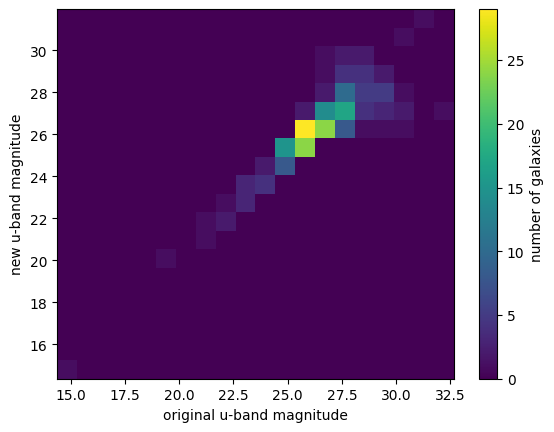

In [23]:
# we have to set the range because there are nans in the new
# dataset with errors, which messes up plt.hist2d
range = [
    [
        np.min(train_data_orig["output"]["mag_u_lsst"]),
        np.max(train_data_orig["output"]["mag_u_lsst"]),
    ],
    [
        np.min(train_data_errs["output"]["mag_u_lsst"]),
        np.max(train_data_errs["output"]["mag_u_lsst"]),
    ],
]
plt.hist2d(
    train_data_orig["output"]["mag_u_lsst"],
    train_data_errs["output"]["mag_u_lsst"],
    range=range,
    bins=20,
    cmap="viridis",
)
plt.xlabel("original u-band magnitude")
plt.ylabel("new u-band magnitude")
plt.colorbar(label="number of galaxies")

You can make this plot for all the other magnitudes if you'd like. 

2. Use `inv_redshift_incompleteness` to mimic redshift dependent incompleteness by removing some galaxies above a redshift threshold. The threshold is given as `pivot_redshift`:

In [24]:
# randomly removes some galaxies above certain redshift threshold
train_data_inc = (
    ri.creation.degraders.spectroscopic_degraders.inv_redshift_incompleteness(
        input=train_data_errs["output"], pivot_redshift=1.0
    )
)

Inserting handle into data store.  input: None, InvRedshiftIncompleteness
Inserting handle into data store.  output: inprogress_output.pq, InvRedshiftIncompleteness


Now let's take a look at what's happened to the data. We can easily see that this has resulted in a smaller sample of galaxies:

In [25]:
print(f"Number of galaxies after cut: {len(train_data_inc["output"])}")
print(f"Number of galaxies in original: {len(train_data_errs["output"])}")

Number of galaxies after cut: 215
Number of galaxies in original: 250


Now let's plot the redshift distributions of our input and output sample. We can see that the distribution is the same below our redshift threshold of 1, and above redshift 1 is where some galaxies are no longer present: 

Text(0, 0.5, 'number of galaxies')

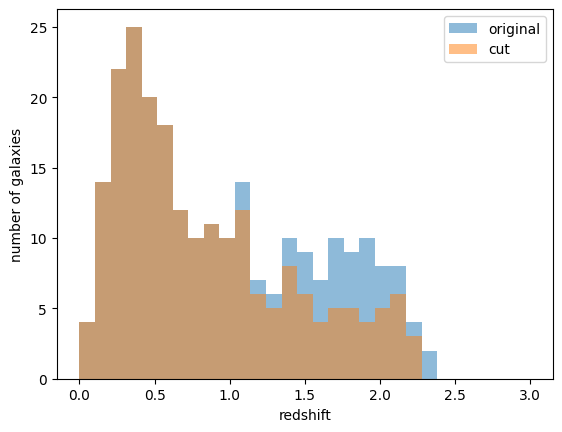

In [26]:
plt.hist(train_data_errs["output"]["redshift"], label="original", **hist_options)
plt.hist(train_data_inc["output"]["redshift"], label="cut", **hist_options)
plt.legend(loc="best")
plt.xlabel("redshift")
plt.ylabel("number of galaxies")

3. Apply `line_confusion` to simulate the effect of misidentified lines. The degrader will misidentify some percentage (`frac_wrong`) of the actual lines (here we're picking `5007.0` Angstroms, which are OIII lines) as the line we pick for `wrong_wavelen`. In this case, we'll pick `3727.0` Angstroms, which are OII lines. 

In [27]:
# simulates the effect of misidentified lines
train_data_conf = ri.creation.degraders.spectroscopic_degraders.line_confusion(
    input=train_data_inc["output"],
    true_wavelen=5007.0,
    wrong_wavelen=3727.0,
    frac_wrong=0.05,
    seed=1337,
)

Inserting handle into data store.  input: None, LineConfusion
Inserting handle into data store.  output: inprogress_output.pq, LineConfusion


Now let's plot the distribution of redshifts we passed into this stage compared to what's been output by the `line_confusion` function. We can see that the output data has a few differences in the distribution, spread across the whole range of redshifts:

Text(0, 0.5, 'number of galaxies')

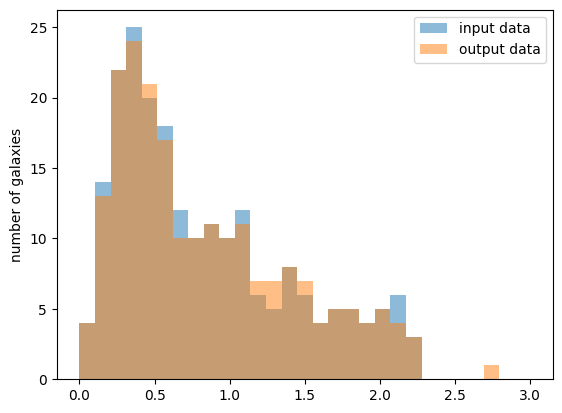

In [28]:
plt.hist(train_data_inc["output"]["redshift"], label="input data", **hist_options)
plt.hist(train_data_conf["output"]["redshift"], label="output data", **hist_options)
plt.legend(loc="best")
plt.ylabel("redshift")
plt.ylabel("number of galaxies")

4. We use `quantity_cut` to cut galaxies based on their specific band magnitudes. This function takes a dictionary of cuts, where you can provide the band name and the values to cut that band on. If one value is given, it's considered a maximum, and if a tuple is given, it's considered a range within which the sample is selected. For this, we'll just set a maximum magnitude for the i band of 25.

In [29]:
# cut some of the data below a certain magnitude
train_data_cut = ri.creation.degraders.quantityCut.quantity_cut(
    input=train_data_conf["output"], cuts={"mag_i_lsst": 25.0}
)

Inserting handle into data store.  input: None, QuantityCut
Inserting handle into data store.  output: inprogress_output.pq, QuantityCut


Now let's check how this has affected the number of galaxies in our sample:

In [30]:
print(f"Number of galaxies after cut: {len(train_data_cut["output"])}")
print(f"Number of galaxies in original: {len(train_data_conf["output"])}")

Number of galaxies after cut: 99
Number of galaxies in original: 215


We can see that this cut the sample down significantly -- now we're at about half the galaxies! 

Now let's plot the distributions to see once again how they compare: 

Text(0, 0.5, 'number of galaxies')

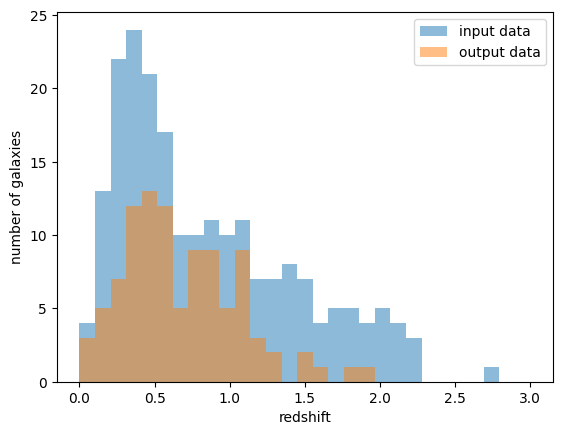

In [33]:
plt.hist(train_data_conf["output"]["redshift"], label="input data", **hist_options)
plt.hist(train_data_cut["output"]["redshift"], label="output data", **hist_options)
plt.legend(loc="best")
plt.xlabel("redshift")
plt.ylabel("number of galaxies")

Now we just need to use the dictionary we made earlier of error column names (`rename_dict`) to rename the error columns, so they match the expected names for the later steps:

In [ ]:
# renames error columns to match DC2
train_data = ri.tools.table_tools.column_mapper(
    input=train_data_cut["output"], columns=rename_dict
)

# renames error columns to match DC2
test_data = ri.tools.table_tools.column_mapper(
    input=test_data_errs["output"], columns=rename_dict, hdf5_groupname=""
)

We can compare the tables before and after we used the `column_mapper` function to see the effect on the column names: 

In [ ]:
train_data_cut["output"].head()

In [ ]:
train_data["output"].head()

## 2. Estimate the redshifts 
Now, we estimate our photometric redshifts. We use the [KNN algorithm](https://rail-hub.readthedocs.io/en/latest/source/estimators.html#k-nearest-neighbor) to estimate our redshifts, varying the minimum and maximum allowed number of neighbours to see its effect on the final result (see [here](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) for more of an explanation of how KNN works). 

To do this, we iterate over a list of the different parameter inputs we want to use for the estimator. In each loop, we estimate the redshifts with the chosen parameters. 

First, we need to pick a few (min, max) neighbour limits that we can iterate over. The default values are (3,7), so let's try values that are around that. We also need a dictionary where we can store the estimated redshifts once we have them:

In [ ]:
# set up parameters to iterate over and the dictionary to store data
nb_params = [(3, 7), (2, 6), (2, 8), (4, 9)]
estimated_photoz = {}

Now we can loop through the two steps required to estimate redshifts: informing the model and using the model to estimate. 

**The algorithm**:  The `K-Nearest Neighbours` algorithm we're using (see [here](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) for more of an explanation of how it works) is a wrapper around `sklearn`'s nearest neighbour (NN) machine learning model. Essentially, it takes a given galaxy, identifies its nearest neighbours in the space, in this case galaxies that have similar colours, and then constructs the photometric redshift PDF as a sum of Gaussians from each neighbour.    

**Inform**: The inform method is training the model that we will use to estimate the redshifts. We will plug in our training data set, and any parameters the model needs. The parameters that we need for this algorithm are the minimum and maximum neighbour limits, which we'll be iterating over. These set the minimum and maximum possible number of neighbours that the model will use to estimate a galaxy's redshift. They do not set the specific number of neighbours it will use, just the range it will test. A larger range will require more computing time. The inform method will also set aside some of the training data set as a validation data set.

**Estimate**: Once our model is trained, we can then use it to estimate the redshifts of the test data set. We provide the estimate algorithm with the test data set, and the model that we've trained, and any other necessary parameters.

Common parameters:
- `nondetect_val`: This tells the code which values are considered non-detections. We pass in `np.nan` here, since that's what we used as the `ndFlag` in the degradation stage for non-detections. 
- `hdf5_groupname`: the dictionary key the code will find the data under. Set to `""` if the data is passed in directly. 

In [ ]:
for nb_min, nb_max in nb_params:

    # use training data to train the informer or model that we will use to estimate redshifts
    inform_knn = ri.estimation.algos.k_nearneigh.k_near_neigh_informer(
        input=train_data["output"],
        nondetect_val=np.nan,
        hdf5_groupname="",
        nneigh_min=nb_min,
        nneigh_max=nb_max,
    )
    # use the trained model to estimate the redshifts of the test data
    knn_estimated = ri.estimation.algos.k_nearneigh.k_near_neigh_estimator(
        input=test_data["output"],
        model=inform_knn["model"],
        nondetect_val=np.nan,
        hdf5_groupname="",
    )

    # add estimated redshifts to a dictionary to store them
    estimated_photoz[(nb_min, nb_max)] = knn_estimated

Now let's take a look at what the output of the estimation stage actually looks like. Most estimation stages output an `Ensemble`, which is a data structure from the package `qp`. For more information, see [the qp documentation](https://qp.readthedocs.io/en/main/user_guide/datastructure.html). 

We're using an `Ensemble` to hold a redshift distribution for each of the galaxies we're estimating. There are two required dictionaries that make up an Ensemble, and one that is optional:
- `.metadata`: Contains information about the whole data structure, like the Ensemble type, and any shared parameters such as the bins of histograms. This is not per-object metadata. 
- `.objdata`: The main data points of the distributions for each object, where each object is a row. 
- `.ancil`: the optional dictionary, containing extra information about each object. It can have arrays that have one or more data points per distribution. 

In [ ]:
# estimated_photoz contains the output of the KNN estimate function for each of our
# parameter sets. Here we print out the result for just one of them. We can see that
# the Ensemble has the same number of rows as galaxies that we input, and some number
# of points per row
print(estimated_photoz[(3, 7)])

We can see that this algorithm outputs Ensembles of class `mixmod`, which are just combinations of Gaussians (for more info see the [qp docs](https://qp.readthedocs.io/en/main/user_guide/parameterizations/mixmod.html)). 

So each distribution in this Ensemble has a set of Gaussians that, added together, make up the distribution. Each distribution is therefore described by a set of means, weights, and standard deviations. The shape portion of the print statement tells us two things: the first number is the number of photo-z distributions, or galaxies, in this `Ensemble`, and the second number tells us how many Gaussians are combined to make up each photo-z distribution. 

Let's take a look at what the different dictionaries look like for this `Ensemble`:  

In [ ]:
# this is the metadata dictionary of that output Ensemble
print(estimated_photoz[(3, 7)]["output"].metadata)

In [ ]:
# this is the actual distribution data of that output Ensemble, which contains
# the data points that describe each photometric redshift probability distribution
print(estimated_photoz[(3, 7)]["output"].objdata)

Typically the ancillary data table includes a photo-z point estimate derived from the PDFs, by default this is the mode of the distribution, called 'zmode' in the ancillary dictionary below:

In [ ]:
# this is the ancillary dictionary of the output Ensemble, which in this case
# contains the zmode, redshift, and distribution type
print(estimated_photoz[(3, 7)]["output"].ancil)

Now let's plot some of these estimated photo-z probability distributions:

In [ ]:
xvals = np.linspace(0, 3, 200)  # we want to cover the whole available redshift space
plt.plot(xvals, estimated_photoz[(3, 7)]["output"][0].pdf(xvals), label="(3,7)")
plt.plot(xvals, estimated_photoz[(2, 6)]["output"][0].pdf(xvals), label="(2,6)")
plt.plot(xvals, estimated_photoz[(2, 8)]["output"][0].pdf(xvals), label="(2,8)")
plt.plot(xvals, estimated_photoz[(4, 9)]["output"][0].pdf(xvals), label="(4,9)")

plt.legend(loc="best", title="(min,max) neighbours")
plt.xlabel("redshift")
plt.ylabel("p(z)")

You can see that the distributions are all quite similar to each other. Some of the runs have little to no difference in their photometric redshift distribution for this galaxy, and any differences that do exist are typically small. This makes sense, since the algorithm is averaging out a set of neighbours, and one more or less shouldn't significantly change that for each individual galaxy. 

Now let's summarize these distributions, so we can get a sense of how the whole distribution of redshift distributions changes with the different parameters. There are a number of summarizing algorithms. Here we'll use two of the most basic: 

1. [**Point Estimate Histogram**](https://rail-hub.readthedocs.io/en/latest/source/summarizers.html#point-estimate-histogram): This algorithm creates a histogram of all the point estimates of the photometric redshifts. By default, the point estimate used is `zmode`, which is usually found in the ancillary dictionary of the distributions. 
2. [**Naive Stacking**](https://rail-hub.readthedocs.io/en/latest/source/summarizers.html#naive-stacking): This algorithm stacks the PDFs of the estimated photometric redshifts together and normalizes the stacked distribution.  

In [ ]:
naive_dict = {}
point_est_dict = {}

for nb_min, nb_max in nb_params:
    # summarize the distributions using point estimate and naive stack summarizers
    point_estimate_ens = ri.estimation.algos.point_est_hist.point_est_hist_summarizer(
        input=estimated_photoz[(nb_min, nb_max)]["output"]
    )
    point_est_dict[(nb_min, nb_max)] = point_estimate_ens
    naive_stack_ens = ri.estimation.algos.naive_stack.naive_stack_summarizer(
        input=estimated_photoz[(nb_min, nb_max)]["output"]
    )
    naive_dict[(nb_min, nb_max)] = naive_stack_ens

Now let's take a look at the output dictionaries for both these functions for one of the distributions:

In [ ]:
print(point_est_dict[(3, 7)])
print(naive_dict[(3, 7)])

These functions output `Ensembles`, just like the KNN estimation algorithm. However, they output two separate `Ensembles`: the 'single_NZ' one contains just one distribution, the actual stacked distribution that has been created. The 'output' one contains a number of bootstrapped distributions, to make further analysis easier.

We're going to focus on the 'single_NZ' distribution here. We'll start by plotting the point estimate summarized distributions for all of the runs, which are histograms:

In [ ]:
# get bin centers and widths
bin_width = (
    point_est_dict[(3, 7)]["single_NZ"].metadata["bins"][1]
    - point_est_dict[(3, 7)]["single_NZ"].metadata["bins"][0]
)
bin_centers = (
    point_est_dict[(3, 7)]["single_NZ"].metadata["bins"][:-1]
    + point_est_dict[(3, 7)]["single_NZ"].metadata["bins"][1:]
) / 2

# plot both histograms to compare
plt.bar(
    bin_centers,
    point_est_dict[(3, 7)]["single_NZ"].objdata["pdfs"],
    width=bin_width,
    alpha=0.7,
    label="(3,7)",
)
plt.bar(
    bin_centers,
    point_est_dict[(2, 6)]["single_NZ"].objdata["pdfs"],
    width=bin_width,
    alpha=0.7,
    label="(2,6)",
)
plt.bar(
    bin_centers,
    point_est_dict[(2, 8)]["single_NZ"].objdata["pdfs"],
    width=bin_width,
    alpha=0.7,
    label="(2,8)",
)
plt.bar(
    bin_centers,
    point_est_dict[(4, 9)]["single_NZ"].objdata["pdfs"],
    width=bin_width,
    alpha=0.7,
    label="(4,9)",
)

plt.legend(loc="best", title="(min, max) neighbours")
plt.xlabel("redshift")
plt.ylabel("N(z)")

You can see that the distributions are not all the same, but the variations that do exist are small. 

Let's plot the summarized distributions from the Naive Stacking algorithm, which are smoothed distributions since it stacked the actual distributions instead of point estimates: 

In [ ]:
# Plot of naive stack summarized distribution
plt.plot(
    naive_dict[(3, 7)]["single_NZ"].metadata["xvals"],
    naive_dict[(3, 7)]["single_NZ"].objdata["yvals"],
    label="(3,7)",
)
plt.plot(
    naive_dict[(2, 6)]["single_NZ"].metadata["xvals"],
    naive_dict[(2, 6)]["single_NZ"].objdata["yvals"],
    label="(2,6)",
)
plt.plot(
    naive_dict[(2, 8)]["single_NZ"].metadata["xvals"],
    naive_dict[(2, 8)]["single_NZ"].objdata["yvals"],
    label="(2,8)",
)
plt.plot(
    naive_dict[(4, 9)]["single_NZ"].metadata["xvals"],
    naive_dict[(4, 9)]["single_NZ"].objdata["yvals"],
    label="(4,9)",
)

plt.legend(loc="best", title="(min, max) neighbours")
plt.xlabel("redshift")
plt.ylabel("N(z)")

Similar to the histograms above, the summarized distributions of all the galaxy photometric redshift probability density functions have some slight differences but are overall quite similar. 

## 4. Use the `Evaluator` stage to calculate some metrics
 **ADD LINKS TO EVALUATION NOTEBOOKS** 
Now that we have a sense of how the distributions of the estimated photometric redshift probability distributions differ, let's get a little more technical. We'll use the `Evaluator` stage to calculate some metrics for each of the distributions of redshifts. For a more detailed look at the available metrics and how to use them, take a look at the 01_Evaluation_by_Type.ipynb notebook. 

Here are the metrics we'll calculate:
1. The [Brier score](https://en.wikipedia.org/wiki/Brier_score), which assesses the accuracy of probabilistic predictions. The lower the score, the better the predictions.  
2. The [Conditional Density Estimation loss](https://vitaliset.github.io/conditional-density-estimation/), which is the averaged squared loss between the true and predicted conditional probability density functions. The lower the score, the better the predicted probability density, in this case, the photometric redshift distributions.

For the evaluation metrics, in general we need the estimated redshift distributions, and the actual redshifts -- these are the pre-degradation redshifts from our initially sampled distribution.

In [ ]:
eval_dict = {}

for nb_min, nb_max in nb_params:
    ### Evaluate the results
    evaluator_stage_dict = dict(
        metrics=["cdeloss", "brier"],
        _random_state=None,
        metric_config={
            # the limits of the redshifts to evaluate the distributions on
            "brier": {"limits": (0, 3.1)},
        },
    )

    the_eval = ri.evaluation.dist_to_point_evaluator.dist_to_point_evaluator(
        input={
            "data": estimated_photoz[(nb_min, nb_max)]["output"],
            "truth": test_data_orig["output"],
        },
        **evaluator_stage_dict,
        hdf5_groupname="",
    )

    # put the evaluation results in a dictionary so we have them
    eval_dict[(nb_min, nb_max)] = the_eval

Now let's take a look at the metrics we calculated, and compare them. The code below just selects the one dictionary output per run that we want to look at, to make the dictionary a little easier to read. 

In [ ]:
results_dict = {key: val["summary"] for key, val in eval_dict.items()}

print(results_dict)

We can see that the metrics are actually quite similar across most of the runs. Typically, when there is a variation it's because the actual number of neighbours chosen is different. This doesn't always happen just because you change the limits, hence the lack of variation across some of these runs. As mentioned above, smaller metrics are better -- in the case of CDE loss that can mean more negative. So those that have the lower CDE loss and Brier scores are the runs that are better estimates 

## 5. Using multiprocessing

Let's say we wanted to do the same as above but with a lot more parameters. We can use the python [`multiprocessing`](https://docs.python.org/3/library/multiprocessing.html#module-multiprocessing) module to run the whole loop concurrently, and speed up the process a little. To do this, we need to turn our loop above into its own function, which takes a the tuple of parameters as an input, and outputs the data that we want to keep. 

In [ ]:
def estimate_photoz(nb_lims):
    """A function to estimate photo-zs using the KNN algorithm, given a minimum
    and maximum number of nearest neighbours. It will then evaluate the performance"""

    # train the informer
    inform_knn = ri.estimation.algos.k_nearneigh.k_near_neigh_informer(
        input=train_data["output"],
        nondetect_val=np.nan,
        model="bpz.pkl",
        hdf5_groupname="",
        nneigh_min=nb_lims[0],
        nneigh_max=nb_lims[1],
    )
    # estimate redshifts
    knn_estimated = ri.estimation.algos.k_nearneigh.k_near_neigh_estimator(
        input=test_data["output"],
        model=inform_knn["model"],
        nondetect_val=np.nan,
        hdf5_groupname="",
    )

    ### Evaluate the results
    evaluator_stage_dict = dict(
        metrics=["cdeloss", "brier"],
        _random_state=None,
        metric_config={
            "brier": {"limits": (0, 3.1)},
        },
    )

    the_eval = ri.evaluation.dist_to_point_evaluator.dist_to_point_evaluator(
        input={"data": knn_estimated["output"], "truth": test_data_orig["output"]},
        **evaluator_stage_dict,
        hdf5_groupname="",
    )

    # summarize the distributions using point estimate and naive stack summarizers
    point_estimate_ens = ri.estimation.algos.point_est_hist.point_est_hist_summarizer(
        input=knn_estimated["output"]
    )
    naive_stack_ens = ri.estimation.algos.naive_stack.naive_stack_summarizer(
        input=knn_estimated["output"]
    )

    return nb_lims, the_eval, point_estimate_ens, naive_stack_ens

Now we need to set up the parameters that we'll be iterating over -- we'll add another four sets of limits to iterate over, with a larger range of possible neighbours, to slow it down a bit. We also need to set up the dictionaries for all the outputs we'll be storing. We'll just store the summarized distributions and evaluator results here, since we're looking for the differences, not the actual redshifts. 

In [ ]:
from multiprocessing.pool import ThreadPool

# set up parameters to iterate over and dictionaries to store data
nb_params = [(3, 7), (2, 6), (2, 8), (4, 9), (5, 10), (1, 9), (2, 9), (3, 10)]
eval_dict_lg = {}
naive_dict_lg = {}
point_est_dict_lg = {}

Now let's actually run our loop. 

We're going to capture the output into the `iter_out_2` variable using the `%%capture` magic command, since running it with this many parameters is going to produce more output than we really need. The `%%timeit -o` magic command times how long the cell takes to run, and stores that result in `iter_out_2`.

The `ThreadPool` class takes the number of processes to use as a parameter, and lets us use the [`imap_unordered`](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool.imap_unordered) utility that accepts the function we'd like to run, as well as the parameters to run it on. Calling `imap_unordered(func, [a, b, c])` returns the iterable `[func(a), func(b), func(c)]` -- though the ordering of the result is not guaranteed. 

We'll try the parallelization with 2 cores first and see how fast it is: 

In [ ]:
%%capture iter_out_2
%%timeit -o
pool = ThreadPool(2) # use 2 cores
for result in pool.imap_unordered(estimate_photoz, nb_params):
    # store the outputs in the dictionaries
    eval_dict_lg[result[0]] = result[1]
    point_est_dict_lg[result[0]] = result[2]
    naive_dict_lg[result[0]] = result[3]

In [ ]:
# print out the first entry of iter_out_2, which is the %%timeit result, stored with the -o option
iter_out_2.outputs[0]

If you want to take a look at the code output, you can do so by uncommenting the line below.

In [ ]:
# show the entire captured output
# iter_out_2.show()

Now let's try re-running on the same set of parameters, but this time with four cores. We'll time this and compare it with the time it took with two cores. As before, we need to set up some dictionaries to store the data in:

In [ ]:
eval_dict_lg_2 = {}
naive_dict_lg_2 = {}
point_est_dict_lg_2 = {}

In [ ]:
%%capture iter_out_4
%%timeit -o
pool = ThreadPool(4) # use 4 cores
for result in pool.imap_unordered(estimate_photoz, nb_params):
    eval_dict_lg_2[result[0]] = result[1]
    point_est_dict_lg_2[result[0]] = result[2]
    naive_dict_lg_2[result[0]] = result[3]

In [ ]:
iter_out_4.outputs[0]

We can see it's actually faster with two cores than four, just because the overhead of assigning the work to each core is still dominating over the actual work being done. If given a larger parameter set, or more data, then the four core parallelization may be worth it. 

### Comparing results

We can use the dictionaries of data we stored to compare the results we've gotten. We'll follow the same method as above, so see there for more explanation if needed.

First we'll take a look at the dictionary of evaluation metrics we calculated, and compare the results for the different parameters:

In [ ]:
results_dict_lg = {key: val["summary"] for key, val in eval_dict_lg.items()}

print(results_dict_lg)

We can see that as before, most of the distributions have similar metrics. Let's plot the summarized distributions of redshift estimates from two different runs with different evalutation metrics to see how the differences have manifested:

In [ ]:
# Plot of naive stack summarized distribution
plt.plot(
    naive_dict_lg[(3, 7)]["single_NZ"].metadata["xvals"],
    naive_dict_lg[(3, 7)]["single_NZ"].objdata["yvals"],
    label="(3,7)",
)
plt.plot(
    naive_dict_lg[(5, 10)]["single_NZ"].metadata["xvals"],
    naive_dict_lg[(5, 10)]["single_NZ"].objdata["yvals"],
    label="(5,10)",
)

plt.legend(loc="best", title="(min, max) neighbours")
plt.xlabel("redshift")
plt.ylabel("p(z)")

As expected, the differences are relatively small, since the differences in the evaluation metrics are relatively small. 

### Larger datasets

This is clearly a toy problem with a small number of galaxies, but presumably you may want to do something similar with a larger dataset and a more intensive algorithm. If you are planning to use very large datasets, we recommend running using a pipeline instead of the interactive notebook method (see instructions [here](https://descraildocs.z27.web.core.windows.net/source/user_guide/pipeline_usage.html)). This method is made for production-level use, and so should be able to operate more efficiently. 